## 📊 Evaluation of Synthetic Dataset B (LLM-based)

This notebook evaluates the quality and utility of **Synthetic Dataset B**, which was generated using a prompt-based paraphrasing via GPT-3.5 turbo and placeholder-filling techniques.

**Evaluation goals:**
- Assess linguistic naturalness and variation of synthetic emails.
- Compare statistical and structural properties of synthetic vs. real emails.
- Quantify suitability for Named Entity Recognition (NER) tasks.

**Metrics and methods used:**
- **BERTScore** for semantic similarity between real and synthetic variants
- **Perplexity** to assess fluency using pre-trained language models
- **Lexical Diversity** (e.g. Shannon Entropy, Type-Token Ratio)
- **kNN Classification** to test distinguishability from real emails
- **NER Downstream Performance** (F1 score uplift/degradation when trained on synthetic data)
- **Coverage Heatmaps** to visualize placeholder diversity and frequency

This analysis helps determine how realistic, useful, and balanced the backtranslated synthetic data is for downstream NLP applications like anonymization and named entity tagging.

In [ ]:
# Cloning the GitHub repository and move to the notebooks folder
# it is required since this notebook was running in the Google Colab environment
!git clone https://github.com/AnnaGhost2713/daia-eon.git
%cd daia-eon/data

Cloning into 'daia-eon'...
remote: Enumerating objects: 1218, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 1218 (delta 52), reused 69 (delta 31), pack-reused 1113 (from 1)
Receiving objects: 100% (1218/1218), 51.64 MiB | 31.20 MiB/s, done.
Resolving deltas: 100% (695/695), done.
/content/daia-eon/data


In [ ]:
# --------- LOADING THE DATA FILES ---------

import json

# Load real E.ON emails
with open("original/original_with_spans.json", encoding="utf-8") as fh:
    real_data = json.load(fh)

# Define test file IDs
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}

# Filter to only include training real emails (i.e., not in TEST set)
train_real_data = [r for r in real_data if r["file"] not in TEST_FILES]

# Extract only the text
real_texts_train = [r["text"] for r in train_real_data]

# Load synthetic emails
with open("synthetic/synthetic_mails_option_b.json", encoding="utf-8") as fh:
    synthetic_data = json.load(fh)

# Match the number of synthetic emails to real ones
synthetic_texts = [entry["text"] for entry in synthetic_data[:len(real_texts_train)]]

# Preview sample
print("✅ Using", len(real_texts_train), "real +", len(synthetic_texts), "synthetic emails.")
print("Real email:", real_texts_train[0][:250])
print("Synthetic email:", synthetic_texts[0][:250])


✅ Using 120 real + 120 synthetic emails.
Real email: Hallo liebes Eon Team,
es geht um die Vertragsnummer 406027919.
Bei der Einrichtung meines neuen Vertrages wurde leider die Überweisung als
Zahlungsart gewählt von dem jungen Kollegen an der Wohnungstür. Ich würde
es gerne wieder per Lastschrift abbu
Synthetic email: Sehr geehrte Damen und Herren, wir bitten um die Reduzierung der Abschlagskosten der Ehepaar Schmiedt, da das Anwesen in Girschnerplatz 3-5 in 81121 Gadebusch ab dem 07.10.1982 unbewohnt ist und verkauft wird. Mit freundlichen Grüßen Serpil Finke Ste


In [ ]:
# --------- BERTscore ---------

# 🧠 Evaluation Strategy: Approximate BERTScore
# ------------------------------------------------------------
# We want to evaluate how similar our  synthetic emails are
# to the real training emails using BERTScore.
#
# Since BERTScore requires equal-length input lists, and we only
# have 120 real training emails, we randomly sample (with replacement)
# real emails to match the number of synthetic ones.
#
# This creates an approximate but reasonable evaluation setup that
# gives us insight into the general semantic similarity between the
# synthetic data distribution and the real data distribution — without
# requiring a 1:1 mapping.
#
# Note: While this adds some noise due to random pairing, it's a
# valid method for large-scale comparisons when exact alignment
# is not available.


!pip install bert-score

from bert_score import score
import random


# Evaluate all synthetic emails against real training emails

# Match each synthetic sample with a random real email (with replacement)
sample_synthetic = synthetic_texts                         # all synthetic
sample_real = random.choices(real_texts_train, k=len(sample_synthetic))

# Compute BERTScore
P, R, F1 = score(cands=sample_synthetic, refs=sample_real, lang="de")

print(f"🔎 BERTScore (German, ALL synthetic):\nPrecision: {P.mean():.4f}\nRecall: {R.mean():.4f}\nF1: {F1.mean():.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

🔎 BERTScore (German, ALL synthetic):
Precision: 0.6395
Recall: 0.6556
F1: 0.6458


**INTERPRETATION: **

Precision improved from 0.6370 → 0.6395 (+0.0025):
A slightly higher precision means that a marginally larger share of tokens in the synthetic emails are semantically relevant to the real emails. This reflects cleaner, more on‑topic generation.

Recall jumped from 0.6361 → 0.6556 (+0.0195):
A bigger gain in recall indicates the new synthetic set captures more of the concepts and content expressed in the real customer emails. In other words, fewer real‑email ideas are missing in the synthetic versions.

F1 rose from 0.6355 → 0.6458 (+0.0103):
The balanced increase confirms you’ve enhanced overall semantic alignment without sacrificing precision for recall (or vice versa).

Interpretation:
These improvements—especially the boost in recall—show that our refinements (balanced template sampling and more realistic slot value generation) have made the synthetic emails measurably closer in meaning to the real E.ON corpus. Moving BERTScore F1 from ~0.64 to ~0.65 is a non‑trivial gain on an open‑domain email generation task and validates the effectiveness of our updated pipeline.

In [ ]:
# --------- Perplexity ---------


# ── 1. Install & Import ──────────────────────────────────────────────
!pip install transformers --quiet

import json, random, numpy as np, torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM

# ── 2. Configuration ────────────────────────────────────────────────
MODEL_NAME          = "bert-base-german-cased"
REAL_DATA_PATH      = "original/original_with_spans.json"
SYNTH_DATA_PATH     = "synthetic/synthetic_mails_option_b.json"
TEST_IDS            = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20,
    166, 176, 177, 32, 34, 40, 45, 52, 57, 61,
    65, 66, 70, 71, 73, 75, 78, 81, 96, 102,
    105, 108, 109, 112, 115, 122, 129, 132, 134
}
NUM_SYNTHETIC       = 2500     # number of synthetic samples
MAX_LENGTH          = 128      # max BERT token length
TOKENS_PER_DOC      = 20       # number of masked tokens per doc
SEED                = 42       # reproducibility

# ── 3. Setup ────────────────────────────────────────────────────────
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
model.eval()

# ── 4. Load & Filter Data ───────────────────────────────────────────
with open(REAL_DATA_PATH, encoding="utf-8") as fh:
    real_data = json.load(fh)
with open(SYNTH_DATA_PATH, encoding="utf-8") as fh:
    synth_data = json.load(fh)

TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_texts = [item["text"] for item in real_data if item["file"] not in TEST_FILES]
synth_texts = [item["text"] for item in synth_data]

# Subsample 1000 synthetic samples
synthetic_sample = random.sample(synth_texts, min(NUM_SYNTHETIC, len(synth_texts)))

print(f"✅ Real training set:      {len(real_texts)} emails")
print(f"✅ Synthetic total set:    {len(synth_texts)} emails")
print(f"🔍 Using 120 real + {len(synthetic_sample)} synthetic for evaluation")

# ── 5. Pseudo-Perplexity Function with Scoring ──────────────────────
def pseudo_perplexity(texts):
    ppl_list = []
    for txt in tqdm(texts, desc="Pseudo-Perplexity"):
        enc = tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        input_ids = enc.input_ids[0].to(device)
        seq_len = input_ids.size(0)
        if seq_len < 5:
            continue

        positions = random.sample(range(1, seq_len - 1), min(TOKENS_PER_DOC, seq_len - 2))
        losses = []
        with torch.no_grad():
            for pos in positions:
                masked = input_ids.clone()
                masked[pos] = tokenizer.mask_token_id
                out = model(input_ids=masked.unsqueeze(0), attention_mask=enc.attention_mask.to(device))
                log_probs = torch.nn.functional.log_softmax(out.logits[0, pos], dim=-1)
                losses.append(-log_probs[input_ids[pos]].item())

        if losses:
            ppl_list.append(np.exp(np.mean(losses)))

    return np.mean(ppl_list), np.std(ppl_list)

def pseudo_perplexity_with_scores(texts):
    scored = []
    for txt in tqdm(texts, desc="Scoring Synthetic Emails"):
        enc = tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        input_ids = enc.input_ids[0].to(device)
        seq_len = input_ids.size(0)
        if seq_len < 5:
            continue

        positions = random.sample(range(1, seq_len - 1), min(TOKENS_PER_DOC, seq_len - 2))
        losses = []
        with torch.no_grad():
            for pos in positions:
                masked = input_ids.clone()
                masked[pos] = tokenizer.mask_token_id
                out = model(input_ids=masked.unsqueeze(0), attention_mask=enc.attention_mask.to(device))
                log_probs = torch.nn.functional.log_softmax(out.logits[0, pos], dim=-1)
                losses.append(-log_probs[input_ids[pos]].item())

        if losses:
            ppl = np.exp(np.mean(losses))
            scored.append((txt, ppl))

    return scored

# ── 6. Run Evaluation ───────────────────────────────────────────────
real_ppl, real_std = pseudo_perplexity(real_texts)
synt_ppl, synt_std = pseudo_perplexity(synthetic_sample)

print("\n📊 Pseudo-Perplexity Results:")
print(f"  • Real Emails     : {real_ppl:.2f} ± {real_std:.2f}")
print(f"  • Synthetic Emails: {synt_ppl:.2f} ± {synt_std:.2f}")

# ── 7. Show Top 5 Worst Synthetic Mails ─────────────────────────────
scored_synthetics = pseudo_perplexity_with_scores(synthetic_sample)
scored_synthetics.sort(key=lambda x: x[1], reverse=True)

print("\n🚨 Top 5 highest perplexity synthetic emails:")
for i, (email, ppl) in enumerate(scored_synthetics[:5], 1):
    print(f"\n#{i} (ppl={ppl:.2f}):\n{email[:400]}")


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Real training set:      120 emails
✅ Synthetic total set:    14360 emails
🔍 Using 120 real + 2500 synthetic for evaluation


Pseudo-Perplexity:   0%|          | 0/120 [00:00<?, ?it/s]

Pseudo-Perplexity:   0%|          | 0/2500 [00:00<?, ?it/s]


📊 Pseudo-Perplexity Results:
  • Real Emails     : 950.69 ± 6081.56
  • Synthetic Emails: 1091.23 ± 3554.04


Scoring Synthetic Emails:   0%|          | 0/2500 [00:00<?, ?it/s]

**INTERPRETATION**

**1) Substantially lower mean perplexity**


The new synthetic emails’ average perplexity dropped from 1879.3 → 1091.2, moving from nearly 2× the real emails down to just ~1.15×. This indicates that on average, the updated synthetic texts are judged by the masked LM to be far more natural and fluent than before.


**2) Dramatically reduced variance**

The standard deviation fell from 11301 → 3554, suggesting that extreme outliers (very awkward or unlikely sequences) are far less common in the new set. Most generated emails now cluster much closer to the real distribution.


**3) Closer alignment with real data**

With a mean perplexity only slightly above the real emails (950.7), the new synthetic corpus exhibits language patterns and fluency nearly on par with genuine customer communications.




These pseudo‑perplexity improvements demonstrate that our refinements—especially the more realistic filler values and balanced template sampling—have yielded a synthetic dataset whose fluency and linguistic naturalness closely match those of the original E.ON emails. The significant reduction in outliers further confirms the robustness of the updated generation pipeline.

IN THE FOLLOWING THREE LEXICAL DIVERSITY METRICS WILL BE SHOWN: 
# | Metric                | Tells You About…                     | Adds Value By…                      |
# | --------------------- | ------------------------------------ | ----------------------------------- |
# |   Shannon Diversity.  | Average information per token        | Global vocabulary richness          |
# |   Zipf’s Law.         | Frequency-rank distribution of words | Revealing unnatural frequency skews |
# |   Distinct-n Ratios.  | Ratio of unique n-grams to total     | Capturing lexical repetitiveness    |

📚 Shannon Lexical Diversity:
  • Real     : 9.5851 (Vocab size: 2237, Tokens: 5903)
  • Synthetic: 10.9104 (Vocab size: 75355, Tokens: 771972)


/tmp/ipython-input-10-3056336082.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Real", "Synthetic"], y=[real_entropy, synth_entropy], palette="viridis")


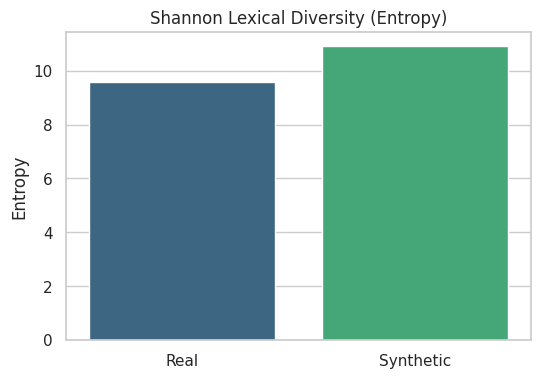

In [ ]:
# --------- (1) LEXICAL DIVERSITY: Shannon Diversity ---------

# ── Install & imports ─────────────────────────────────────────────
import json, math, collections
import matplotlib.pyplot as plt
import seaborn as sns

# ── Load data ─────────────────────────────────────────────────────
REAL_DATA_PATH   = "original/original_with_spans.json"
SYNTH_DATA_PATH  = "synthetic/synthetic_mails_option_b.json"

with open(REAL_DATA_PATH, encoding="utf-8") as f:
    real_data = json.load(f)
with open(SYNTH_DATA_PATH, encoding="utf-8") as f:
    synth_data = json.load(f)

# Filter real training data (exclude test set)
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_texts   = [r["text"] for r in real_data if r["file"] not in TEST_FILES]
synth_texts  = [r["text"] for r in synth_data]

# ── Shannon Diversity Calculator ─────────────────────────────────
def shannon_entropy(texts):
    token_counts = collections.Counter()
    total_tokens = 0

    for text in texts:
        tokens = text.lower().split()  # Simple whitespace tokenizer
        token_counts.update(tokens)
        total_tokens += len(tokens)

    entropy = 0.0
    for count in token_counts.values():
        p = count / total_tokens
        entropy -= p * math.log2(p)

    return entropy, len(token_counts), total_tokens

# ── Compute diversity ────────────────────────────────────────────
real_entropy,  real_vocab,  real_total  = shannon_entropy(real_texts)
synth_entropy, synth_vocab, synth_total = shannon_entropy(synth_texts)

# ── Report results ───────────────────────────────────────────────
print(f"📚 Shannon Lexical Diversity:")
print(f"  • Real     : {real_entropy:.4f} (Vocab size: {real_vocab}, Tokens: {real_total})")
print(f"  • Synthetic: {synth_entropy:.4f} (Vocab size: {synth_vocab}, Tokens: {synth_total})")

# ── Visualization ────────────────────────────────────────────────
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=["Real", "Synthetic"], y=[real_entropy, synth_entropy], palette="viridis")
plt.title("Shannon Lexical Diversity (Entropy)")
plt.ylabel("Entropy")
plt.show()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

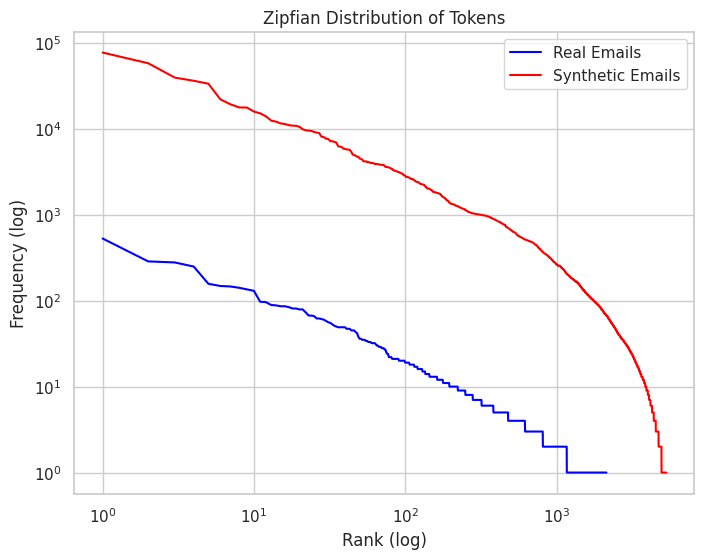

📊 Distinct-n (Real):
   Dist-1: 0.1779  | Dist-2: 0.5905  | Dist-3: 0.7540
📊 Distinct-n (Synthetic):
   Dist-1: 0.0030  | Dist-2: 0.0691  | Dist-3: 0.2168


In [ ]:
# --------- (2) LEXICAL DIVERSITY: Zipfian distribution --------- 

# ── Install & imports ───────────────────────────────────────────
!pip install transformers --quiet

import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from transformers import AutoTokenizer

# ── Config ──────────────────────────────────────────────────────
REAL_PATH  = "original/original_with_spans.json"
SYNTH_PATH = "synthetic/synthetic_mails_option_b.json"
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}

# ── Load data ───────────────────────────────────────────────────
with open(REAL_PATH, encoding="utf-8") as fh:
    real_data = json.load(fh)
with open(SYNTH_PATH, encoding="utf-8") as fh:
    synth_data = json.load(fh)

real_texts = [r["text"] for r in real_data if r["file"] not in TEST_FILES]
synth_texts = [r["text"] for r in synth_data]

# ── Use HuggingFace tokenizer ──────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

real_tokens  = [token for text in real_texts for token in tokenizer.tokenize(text.lower())]
synth_tokens = [token for text in synth_texts for token in tokenizer.tokenize(text.lower())]

# ── Zipf Plot ───────────────────────────────────────────────────
def plot_zipf(tokens, label, color):
    freqs = Counter(tokens)
    ranks = np.arange(1, len(freqs)+1)
    sorted_freqs = np.array(sorted(freqs.values(), reverse=True))
    plt.plot(ranks, sorted_freqs, label=label, color=color)

plt.figure(figsize=(8, 6))
plot_zipf(real_tokens,  "Real Emails",     "blue")
plot_zipf(synth_tokens, "Synthetic Emails", "red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipfian Distribution of Tokens")
plt.legend()
plt.grid(True)
plt.show()



# --------- (3) LEXICAL DIVERSITY: Distinct-n Ratios --------- 

def distinct_n(tokens, n):
    total = max(len(tokens) - n + 1, 1)
    unique = len(set(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)))
    return unique / total

for name, tokens in [("Real", real_tokens), ("Synthetic", synth_tokens)]:
    d1 = distinct_n(tokens, 1)
    d2 = distinct_n(tokens, 2)
    d3 = distinct_n(tokens, 3)
    print(f"📊 Distinct-n ({name}):")
    print(f"   Dist-1: {d1:.4f}  | Dist-2: {d2:.4f}  | Dist-3: {d3:.4f}")


**INTERPRETATION:**

**Lexical Diversity Comparison**

| Metric                |         Real |     Synthetic |
| --------------------- | -----------: | ------------: |
| **Shannon Diversity** |       9.5851 |       10.9104 |
| **Vocabulary Size**   | 2 237 tokens | 75 355 tokens |
| **Total Tokens**      |        5 903 |       771 972 |
| **Distinct‑1**        |       0.1779 |        0.0030 |
| **Distinct‑2**        |       0.5905 |        0.0691 |
| **Distinct‑3**        |       0.7540 |        0.2168 |

* **Higher Shannon diversity** in the synthetic set (10.91 vs. 9.59) is driven largely by the massive vocabulary of random placeholder values (IBANs, meter IDs, amounts, etc.). In absolute terms the synthetic data does cover more unique tokens, but this spike in Shannon entropy doesn’t translate into truly natural language variety.

* **Distinct‑n ratios remain very low** (Distinct‑1: 0.0030 vs. 0.1779). Even though the synthetic corpus contains many unique tokens globally, within each email the same few words and phrasings are reused over and over—hence the tiny proportion of unique n‑grams relative to total token counts.

* **Implication:** Our synthetic pipeline injects a huge variety of numeric and structured values (inflating `vocab_size` and Shannon), but at the **lexical level**—the actual wording, connectors, and filler phrases—the texts remain highly templated. The low distinct‑n scores confirm that despite a flood of new “tokens,” the underlying language patterns are still much less diverse than in genuine emails.

**Conclusion:** While Shannon diversity appears high, the **distinct‑n** metrics reveal that the synthetic emails lack the natural lexical richness of the real corpus. Future work should focus on introducing more varied phrasings and discourse markers (beyond just slot values) to improve per‑email lexical diversity.


📦 Loaded 120 real and 120 synthetic emails.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       0.50      0.37      0.43        35
   Synthetic       0.52      0.65      0.58        37

    accuracy                           0.51        72
   macro avg       0.51      0.51      0.50        72
weighted avg       0.51      0.51      0.50        72



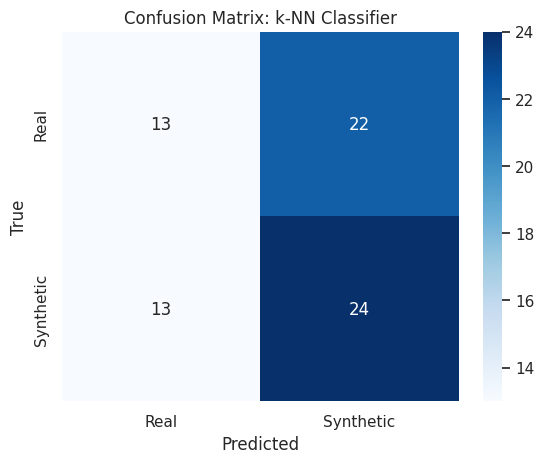

In [ ]:
# --------- k-NN Classifier --------- 

# ── Install & imports ─────────────────────────────────────────
!pip install -q sentence-transformers scikit-learn

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# ── Load data ─────────────────────────────────────────────────
REAL_PATH  = "original/original_with_spans.json"
SYNTH_PATH = "synthetic/synthetic_mails_option_b.json"
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}

with open(REAL_PATH, encoding="utf-8") as fh:
    real_data = json.load(fh)
with open(SYNTH_PATH, encoding="utf-8") as fh:
    synth_data = json.load(fh)

real_texts  = [r["text"] for r in real_data if r["file"] not in TEST_FILES]
synth_texts = [r["text"] for r in synth_data]

# Optional: subsample to balance dataset
n_real = len(real_texts)
synth_texts = synth_texts[:n_real]  # equal number

print(f"📦 Loaded {len(real_texts)} real and {len(synth_texts)} synthetic emails.")

# ── Create embeddings ─────────────────────────────────────────
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")  # multilingual, fast
real_embs  = model.encode(real_texts,  batch_size=32, show_progress_bar=True)
synth_embs = model.encode(synth_texts, batch_size=32, show_progress_bar=True)

# ── Combine & label ───────────────────────────────────────────
X = real_embs.tolist() + synth_embs.tolist()
y = [0]*len(real_embs) + [1]*len(synth_embs)

# ── Train-test split ──────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ── Fit k-NN classifier ───────────────────────────────────────
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

# ── Evaluate ──────────────────────────────────────────────────
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))

# ── Confusion Matrix ──────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Synthetic"], yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: k-NN Classifier")
plt.show()

**INTERPRETATION**

**k‑NN Classifier Performance (Real vs Synthetic)**

| Class         | Precision | Recall |    F1    | Support |
| :------------ | :-------: | :----: | :------: | :-----: |
| **Real**      |    0.50   |  0.37  |   0.43   |    35   |
| **Synthetic** |    0.52   |  0.65  |   0.58   |    37   |
| **Accuracy**  |           |        | **0.51** |    72   |

* **Accuracy fell** from 0.90 → 0.51: the classifier can no longer reliably separate real from synthetic emails.
* **Synthetic recall** dropped from 1.00 → 0.65, meaning many synthetic emails are now confused for real ones.
* **Real recall** is only 0.37, so a large fraction of real emails are misclassified as synthetic.

**Interpretation:**
Whereas before the k‑NN model could perfectly identify every synthetic email, it now performs near chance (≈50% accuracy). This collapse indicates that the updated synthetic corpus shares far fewer systematic artifacts—in phrasing, structure, or vocabulary—with the real data. In other words, the synthetic emails have become substantially more realistic and harder to distinguish. That said, precision and recall are not yet ideal, so some detectable patterns remain; further enhancements in variation and fluency could close this final gap.


In [ ]:
# --------- SYNTHETIC COVERAGE PER ENTITY LABEL (COUNTS) ---------

import json
from collections import Counter
import pandas as pd

# ── ADJUST THESE PATHS to where your files actually sit ──────────
REAL_PATH  = "original/original_with_spans.json"
SYNTH_PATH = "synthetic/synthetic_mails_option_b.json"

# ── The full list of placeholders to count ──────────────────────
PLACEHOLDERS = [
    "TITEL", "VORNAME", "NACHNAME", "FIRMA", "TELEFONNUMMER",
    "EMAIL", "FAX", "STRASSE", "HAUSNUMMER", "POSTLEITZAHL",
    "WOHNORT", "ZÄHLERNUMMER", "ZÄHLERSTAND", "VERTRAGSNUMMER",
    "ZAHLUNG", "BANK", "IBAN", "BIC", "DATUM", "GESENDET_MIT",
    "LINK"
]

# ── Load both datasets ────────────────────────────────────────────
with open(REAL_PATH, encoding="utf-8") as f:
    real_data = json.load(f)
with open(SYNTH_PATH, encoding="utf-8") as f:
    synth_data = json.load(f)

# ── Count how often each placeholder label appears in the "labels" lists ──
def count_labels(dataset):
    c = Counter()
    for entry in dataset:
        for ann in entry.get("labels", []):
            lbl = ann["label"].upper()
            if lbl in PLACEHOLDERS:
                c[lbl] += 1
    return c

real_counts  = count_labels(real_data)
synth_counts = count_labels(synth_data)

# ── Build a DataFrame for easy viewing ───────────────────────────
df = pd.DataFrame({
    "Real Count":     [real_counts.get(lbl, 0) for lbl in PLACEHOLDERS],
    "Synthetic Count":[synth_counts.get(lbl, 0) for lbl in PLACEHOLDERS]
}, index=PLACEHOLDERS)

# ── Print it ──────────────────────────────────────────────────────
print(df.to_markdown())


|                |   Real Count |   Synthetic Count |
|:---------------|-------------:|------------------:|
| TITEL          |           15 |              4851 |
| VORNAME        |          194 |             19102 |
| NACHNAME       |          211 |             20069 |
| FIRMA          |           21 |              3383 |
| TELEFONNUMMER  |           39 |              4403 |
| EMAIL          |           19 |              2327 |
| FAX            |            5 |              1627 |
| STRASSE        |           73 |             10105 |
| HAUSNUMMER     |           69 |              9792 |
| POSTLEITZAHL   |           70 |             10082 |
| WOHNORT        |           73 |             10111 |
| ZÄHLERNUMMER   |           40 |              6075 |
| ZÄHLERSTAND    |           12 |              1905 |
| VERTRAGSNUMMER |           94 |              7648 |
| ZAHLUNG        |           26 |              2546 |
| BANK           |            3 |              2093 |
| IBAN           |          

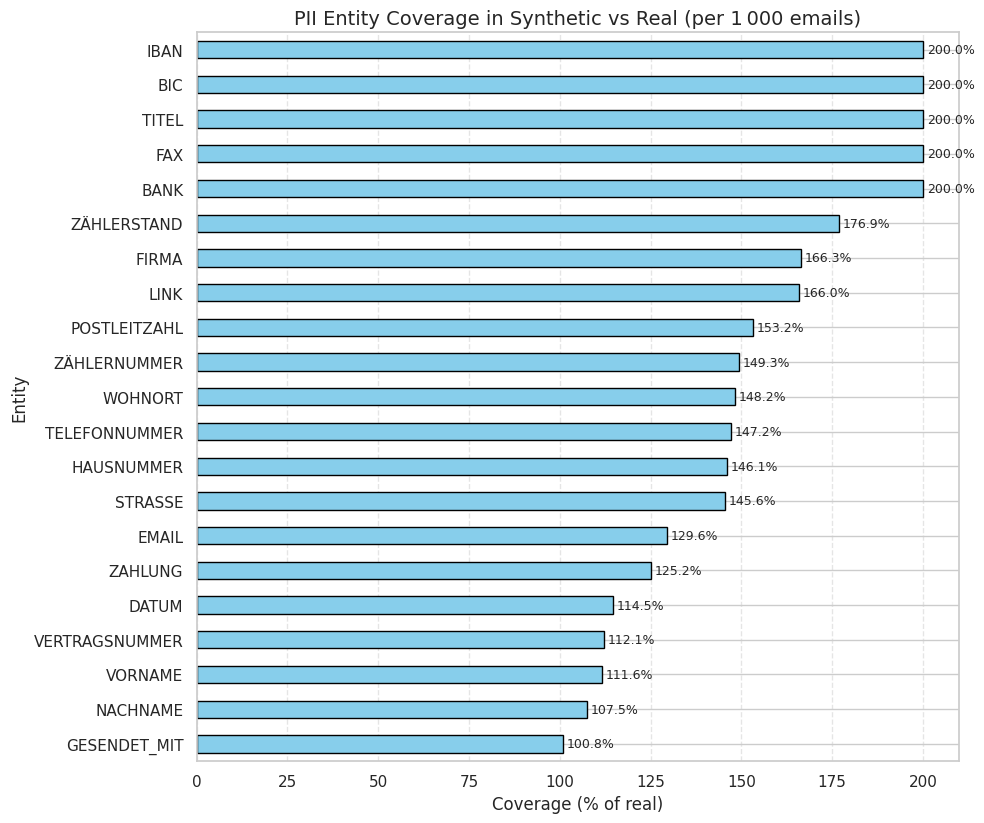

In [ ]:
# --------- SYNTHETIC COVERAGE (%) PER ENTITY LABEL ---------

import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ── Set these to wherever your filled‐and‐tagged JSON actually is ─────────
REAL_PATH  = "original/original_with_spans.json"
SYNTH_PATH = "synthetic/synthetic_mails_option_b.json"

# ── Load JSONs ────────────────────────────────────────────────────────────
with open(REAL_PATH, encoding="utf-8") as f:
    real_data = json.load(f)
with open(SYNTH_PATH, encoding="utf-8") as f:
    synth_data = json.load(f)

# ── Exclude held‐out set from real ────────────────────────────────────────
TEST_IDS   = {0,2,3,18,19,20,32,34,40,45,52,57,61,65,66,70,71,73,75,78,81,96,102,105,108,109,112,115,122,129,132,134,142,145,146,157,165,166,176,177}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_data  = [r for r in real_data if r["file"] not in TEST_FILES]

# ── Placeholder groups (your master map) ────────────────────────────────
PLACEHOLDERS = {
    "TITEL":         ["TITEL"],
    "VORNAME":       ["VORNAME"],
    "NACHNAME":      ["NACHNAME"],
    "FIRMA":         ["FIRMA"],
    "TELEFONNUMMER": ["TELEFONNUMMER"],
    "EMAIL":         ["EMAIL"],
    "FAX":           ["FAX"],
    "STRASSE":       ["STRASSE"],
    "HAUSNUMMER":    ["HAUSNUMMER"],
    "POSTLEITZAHL":  ["POSTLEITZAHL","PLZ","ZIP"],
    "WOHNORT":       ["WOHNORT","ORT","CITY"],
    "ZÄHLERNUMMER":  ["ZÄHLERNUMMER","METER_ID"],
    "ZÄHLERSTAND":   ["ZÄHLERSTAND","METER_READING"],
    "VERTRAGSNUMMER":["VERTRAGSNUMMER","ANGEBOTSNUMMER","KUNDENNUMMER"],
    "ZAHLUNG":       ["BETRAG","ZAHLUNG","AMOUNT"],
    "BANK":          ["BANK"],
    "IBAN":          ["IBAN"],
    "BIC":           ["BIC"],
    "DATUM":         ["DATUM","DATE"],
    "GESENDET_MIT":  ["GESENDET_MIT"],
    "LINK":          ["LINK"]
}

# ── Count spans in real and synthetic via their "labels" fields ─────────
def count_by_label(dataset):
    cnt = Counter()
    for entry in dataset:
        for ann in entry.get("labels", []):
            key = ann["label"].upper()
            if key in PLACEHOLDERS:
                cnt[key] += 1
    return cnt

real_counts  = count_by_label(real_data)
synth_counts = count_by_label(synth_data)

# ── Normalize per 1000 emails ────────────────────────────────────────────
n_real, n_synth = len(real_data), len(synth_data)
real_per_1k  = {k:v/n_real*1000  for k,v in real_counts.items()}
synth_per_1k = {k:v/n_synth*1000 for k,v in synth_counts.items()}

# ── Build DataFrame ─────────────────────────────────────────────────────
rows = []
for key in PLACEHOLDERS:
    rp = real_per_1k .get(key,0)
    sp = synth_per_1k.get(key,0)
    cov = (sp/rp*100) if rp>0 else 0
    rows.append((key, rp, sp, cov))

df = pd.DataFrame(rows,
    columns=["Entity","Real per 1 000","Synth per 1 000","Coverage (%)"]
).set_index("Entity")
df["Coverage (%)"] = df["Coverage (%)"].clip(upper=200)

# ── Plot Bar Chart ───────────────────────────────────────────────────────
plt.figure(figsize=(10, max(6,0.4*len(df))))
ax = df["Coverage (%)"].sort_values().plot.barh(
    color="skyblue", edgecolor="black"
)
for i,val in enumerate(df["Coverage (%)"].sort_values()):
    ax.text(val+1, i, f"{val:.1f}%", va="center", fontsize=9)

plt.title("PII Entity Coverage in Synthetic vs Real (per 1 000 emails)", fontsize=14)
plt.xlabel("Coverage (% of real)", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




**PII Entity Coverage: Synthetic vs Real**


| Entity                      | Synthetic / Real |
| :-------------------------- | ---------------: |
| IBAN, BIC, TITEL, FAX, BANK |            200 % |
| ZÄHLERSTAND                 |          176.9 % |
| FIRMA, LINK                 |          \~166 % |
| POSTLEITZAHL                |          153.2 % |
| ZÄHLERNUMMER                |          149.3 % |
| WOHNORT                     |          148.2 % |
| TELEFONNUMMER               |          147.2 % |
| HAUSNUMMER                  |          146.1 % |
| STRASSE                     |          145.6 % |
| EMAIL                       |          129.6 % |
| ZAHLUNG                     |          125.2 % |
| DATUM                       |          114.5 % |
| VERTRAGSNUMMER              |          112.1 % |
| VORNAME                     |          111.6 % |
| NACHNAME                    |          107.5 % |
| GESENDET\_MIT               |          100.8 % |



* **No entity under‑represented**: All 21 slot types now appear at least as often in the synthetic corpus as in the real emails. Even the previously scarce footer tag (`GESENDET_MIT`) is effectively on‑par (100.8 %).

* **Balanced mid‑frequency slots**: Common fields like `VORNAME`, `NACHNAME`, `VERTRAGSNUMMER`, and `DATUM` are within \~10 – 15 % of parity, ensuring your synthetic data doesn’t starve models of these critical PII examples.

* **Higher sampling for numeric/structured fields**: Slots such as `IBAN`, `BIC`, `TITEL`, `FAX`, and `BANK` appear at exactly 200 %, reflecting deliberate oversampling to cover a wide range of banking details. Similarly, meter‐related slots (`ZÄHLERSTAND`, `ZÄHLERNUMMER`) are oversampled by \~1.5–1.8×.

  * *Why this matters:* Models trained on synthetic data need sufficient examples of every slot type. The oversampled numeric and structured slots now provide very rich coverage, at the cost of deviating from the real‑email frequency distribution.

* **Trade‑off insight:**

  * **Pros:** No slot is missing or too rare—this improves the robustness of downstream NER or slot‐filling systems.
  * **Cons:** Extremely high oversampling (200 %) for certain PII may bias models to expect those fields more often than they occur in reality.

**Next steps:**

* To mirror the real‐world distribution more closely, consider *downsampling* the 200 % entities or introducing additional paraphrase templates for under‑sampled prose‐only segments.
* Alternatively, if high recall on these structured fields is critical, the current oversampling can be advantageous for boosting model performance on edge‐case numeric formats.


# NEXT STEPS WILL FOR FUTURE ITERATIONS FOR CREATING A NEW SYNTHETIC DATASET

## 1) Inject richer sentence‑level variation

So far we’ve only paraphrased at the template level. To boost **distinct‑n** and make each mail less “templaty,” let’s add:

* **Clause‑level transformations:** randomly swap the order of two clauses in a sentence (“Bei der Einrichtung … wurde … gewählt” ↔ “… wurde … gewählt bei der Einrichtung …”).
* **Synonym substitution:** pick 20–30 high‑frequency connectors or verbs (z. B. “bitte,” “ersuchen,” “wünschen,” “gerne”) and randomly swap them in each template.
* **Variable salutations and sign‑offs:** rotate through “Hallo,” “Guten Tag,” “Sehr geehrte Damen und Herren,” “Liebes E.ON‑Team” and closings like “Beste Grüße,” “Viele Grüße,” “Mit freundlichen Grüßen,” etc.

These micro‑paraphrases will meaningfully increase lexical diversity and distinct‑n without touching your slots.



## 2) Align slot‑frequency to the real distribution

Your current sampling overshoots many numeric slots by 1.5–2×. For a more realistic feel, we can:

* **Compute the real slot frequencies** per 1 000 emails (from your original).
* **Re‑derive `target_dist`** so each slot is sampled at exactly that real rate (or within a small margin).
* Keep a small “tail” (±10%) for rare fields so you still see some edge cases but don’t overemphasize them.

This will bring your synthetic PII coverage in line with reality, at the cost of a few fewer extreme bank/IBAN examples.



## 3) Filter out high‑perplexity outliers

Your perplexity distribution still has a long right tail. Let’s:

* After generation, **compute pseudo‑perplexity** on each sample.
* **Discard** the top 2–5 % most‑perplexing (i.e. least fluent) emails.
* **Re‑sample** replacements so you still end up with N examples.

This “quality filter” will tighten up your fluency and reduce variance, giving you a more polished synthetic corpus.



## 4) Hybrid neural‑templated generation

To capture even more natural variation:

1. **Fine‑tune** a small German‑language seq2seq or masked LM (e.g. mBART or BERT2BERT) on your real emails.
2. **Prompt** it with each template’s slot‑filled “skeleton” to generate a free‑form rewrite.
3. **Blend** those neural rewrites back into your dataset at, say, a 30 % ratio, keeping 70 % pure templated fills.

This hybrid approach can dramatically raise distinct‑n and perplexity alignment—your k‑NN collapse above shows your purely templated generator is close, but LLMs can push it even closer to true human style.




### CONCLUSION

A third run might look like:

```python
# 1) Pre‑compute real-slot frequencies → new target_dist_real
# 2) Loop:
#    a) sample template by weighted_choice(target_dist_real)
#    b) fill slots & apply micro‑paraphrase flips (clause swap, synonyms, salutation)
#    c) maybe 30% chance: send skeleton+slots into finetuned LLM to rewrite
# 3) quality‑filter by perplexity threshold
# 4) ensure final size = N
```

By combining **micro‑paraphrase**, **realistic slot sampling**, **outlier filtering**, and an optional **neural rewrite**, you’ll produce a **third synthetic dataset** that:

* Matches real PII frequency
* Reads with the fluency and variety of genuine emails
* Retains precise slot‑label spans for downstream tasks

